<a href="https://colab.research.google.com/github/CurtCalledBurt/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/curtismckendrick/Downloads/games.csv')

In [0]:
df.columns.tolist()

['id',
 'type',
 'name',
 'yearpublished',
 'minplayers',
 'maxplayers',
 'playingtime',
 'minplaytime',
 'maxplaytime',
 'minage',
 'users_rated',
 'average_rating',
 'bayes_average_rating',
 'total_owners',
 'total_traders',
 'total_wanters',
 'total_wishers',
 'total_comments',
 'total_weights',
 'average_weight']

In [0]:
# feature selection

# We try predicting 'average_rating' and see what happens with that.

target = 'average_rating'

# Obviously we wouldn't know the bayes_average_rating if we knew the average rating, so we remove that from
# the features. And I'm considering removing the 2 weight columns again, because I still have no idea what 
# they are. 

things_we_cannot_know = ['bayes_average_rating']

things_we_do_not_need = ['name', 'type', 'id']

features = df.columns.drop([target] + things_we_cannot_know + things_we_do_not_need)
X = df[features]
y = df[target]

In [0]:
# train/test/val split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2019)

In [0]:
# train/test/val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=2019)
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((45738, 15), (45738,), (20328, 15), (20328,), (15246, 15), (15246,))

In [0]:
# quick and dirty baseline regressor

def baseline_Regressor(target):
  from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

  # making a list of the same size as 'target' 
  # with the mean of the target as the only possible entree
  mean_target = target.mean()
  pred_baseline = [mean_target] * len(target)
  
  #calculating baseline error and score
  mae = mean_absolute_error(target, pred_baseline)
  mse = mean_squared_error(target, pred_baseline)
  r2 = r2_score(target, pred_baseline)
  
  # printing the errors and scores
  print('Baseline MAE: ', mae)
  print('Baseline MSE: ', mse)
  print('Baseline R^2: ', r2)

In [0]:
y_train.isna().sum()

0

In [0]:
X_train['users_rated'].isna().sum()

0

In [0]:
# get a list of baseline predictions
y_pred_base = baseline_Regressor(y_train)

Baseline MAE:  2.711469150949111
Baseline MSE:  9.321468469749549
Baseline R^2:  0.0


In [0]:
# more robust modelling
# we'll start with a random forest before making our way to xgboost
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=150, random_state=2019, n_jobs=-1)
)
# Fit the model
pipeline.fit(X_train, y_train);

In [0]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


#make a prediction on the train set
y_pred = pipeline.predict(X_train)

# MAE of train set
mae = mean_absolute_error(y_train, y_pred)
print('MAE Train Error: ', mae)

# RMSE of train set
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print('RMSE Train Error: ', rmse)

# R2 score of train set
r2 = r2_score(y_train, y_pred)
print('Train R^2 Score: ', r2)


print('\n')


# make prediction on the val set
y_pred = pipeline.predict(X_val)

# MAE of val set
mae = mean_absolute_error(y_val, y_pred)
print('MAE Val Error: ', mae)

# RMSE of val set
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print('RMSE Val Error: ', rmse)

# R2 score of val set
r2 = r2_score(y_val, y_pred)
print('Val R^2 Score: ', r2)

MAE Train Error:  0.225298161233403
RMSE Train Error:  0.39027141167513846
Train R^2 Score:  0.9836601094274797


MAE Val Error:  0.5841072198455923
RMSE Val Error:  0.9932021499061355
Val R^2 Score:  0.8945718078292232


In [0]:
from xgboost import XGBRegressor

imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.fit_transform(X_train)


pipeline_boost = make_pipeline(
    SimpleImputer(strategy='median'),
    XGBRegressor(objective='reg:squarederror',
            n_estimators=1000, 
            random_state=2019,
            learning_rate = 0.5,
            n_jobs=-1)
)




model = XGBRegressor(objective='reg:squarederror',
            n_estimators=1000, 
            random_state=2019,
            learning_rate = 0.5,
            n_jobs=-1
            )

eval_set = [ 
    (X_train_imputed, y_train), 
    (X_val_imputed, y_val) 
           ]

model.fit(X_train_imputed, y_train,
         eval_set=eval_set,
         eval_metric= 'mae',
         early_stopping_rounds=50);

pipeline_boost.fit(X_train_imputed, y_train)

[0]	validation_0-mae:2.06516	validation_1-mae:2.06067
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 50 rounds.
[1]	validation_0-mae:1.19791	validation_1-mae:1.19438
[2]	validation_0-mae:0.859297	validation_1-mae:0.851299
[3]	validation_0-mae:0.73839	validation_1-mae:0.728952
[4]	validation_0-mae:0.695918	validation_1-mae:0.686166
[5]	validation_0-mae:0.678737	validation_1-mae:0.667684
[6]	validation_0-mae:0.676067	validation_1-mae:0.665208
[7]	validation_0-mae:0.673323	validation_1-mae:0.662096
[8]	validation_0-mae:0.668499	validation_1-mae:0.656787
[9]	validation_0-mae:0.664781	validation_1-mae:0.65261
[10]	validation_0-mae:0.665486	validation_1-mae:0.653926
[11]	validation_0-mae:0.664937	validation_1-mae:0.653502
[12]	validation_0-mae:0.662733	validation_1-mae:0.651281
[13]	validation_0-mae:0.662429	validation_1-mae:0.651446
[14]	validation_0-mae:0.662508	validation_1-mae:0.651245
[15]

Pipeline(memory=None,
         steps=[('simpleimputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='median',
                               verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.5,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=1000, n_jobs=-1,
                              nthread=None, objective='reg:squarederror',
                              random_state=2019, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, seed=None, silent=None,
                              subsample=1, verbosity=1))],
         ver

In [0]:
y_pred = model.predict(X_train_imputed)
print('Train MAE: ', mean_absolute_error(y_train, y_pred))
print('Train RMSE: ', np.sqrt(mean_squared_error(y_train, y_pred)))
print('Train R2: ', r2_score(y_train, y_pred))

print('\n')

y_pred = model.predict(X_val_imputed)
print('Val MAE: ', mean_absolute_error(y_val, y_pred))
print('Val RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))
print('Val R2: ', r2_score(y_val, y_pred))

Train MAE:  0.6092844171745581
Train RMSE:  0.9828667149384276
Train R2:  0.8963653653425047


Val MAE:  0.619484039820385
Val RMSE:  0.9921008963533039
Val R2:  0.8948054738641488


In [0]:
y_train.shape, y_val.shape, y_pred.shape

((45738,), (15246,), (15246,))

In [0]:
features

Index(['yearpublished', 'minplayers', 'maxplayers', 'playingtime',
       'minplaytime', 'maxplaytime', 'minage', 'users_rated', 'total_owners',
       'total_traders', 'total_wanters', 'total_wishers', 'total_comments',
       'total_weights', 'average_weight'],
      dtype='object')

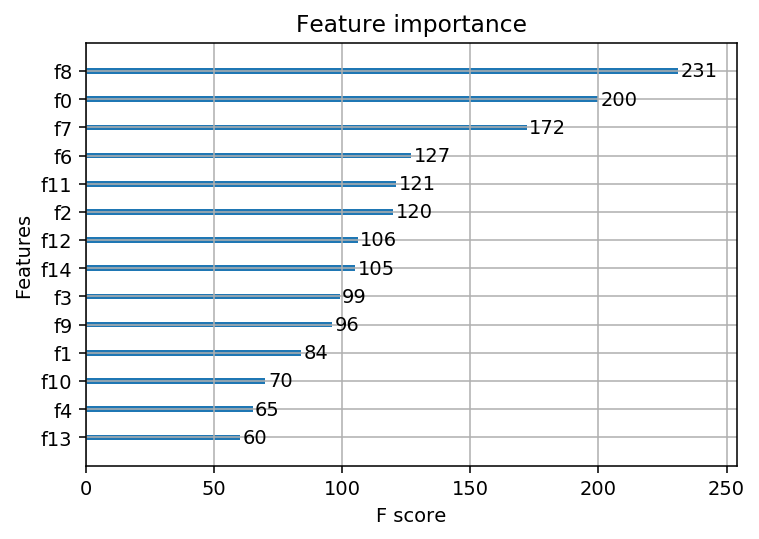

In [0]:
from xgboost import plot_importance

plot_importance(model)
plt.show()

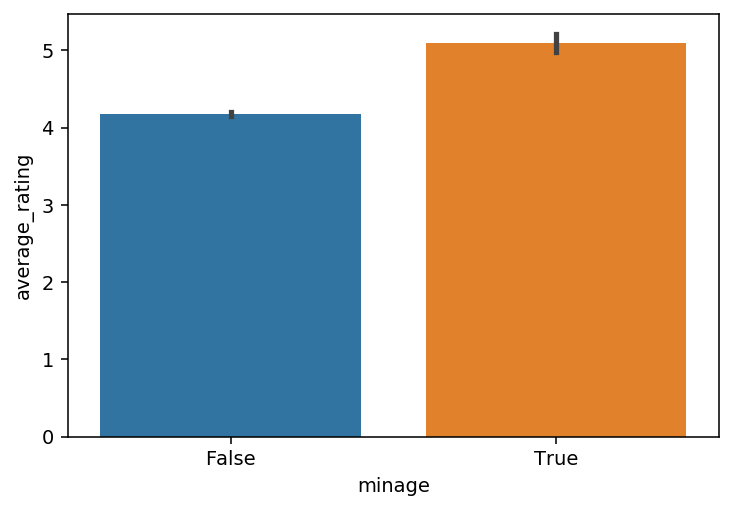

In [0]:
# Plotting begins here
import seaborn as sns

sns.barplot(X_train['minage'] >= 14, y_train);

In [0]:
plt.rcParams['figure.dpi'] = 140

# pdp currently can't handle NaN values, so we just remake our datasets
# without them so it can work with them
X_train_no_na = X_train.copy()
X_train_no_na = X_train_no_na.fillna(X_train.median())

X_val_no_na = X_val.copy()
X_val_no_na = X_val_no_na.fillna(X_val.median())

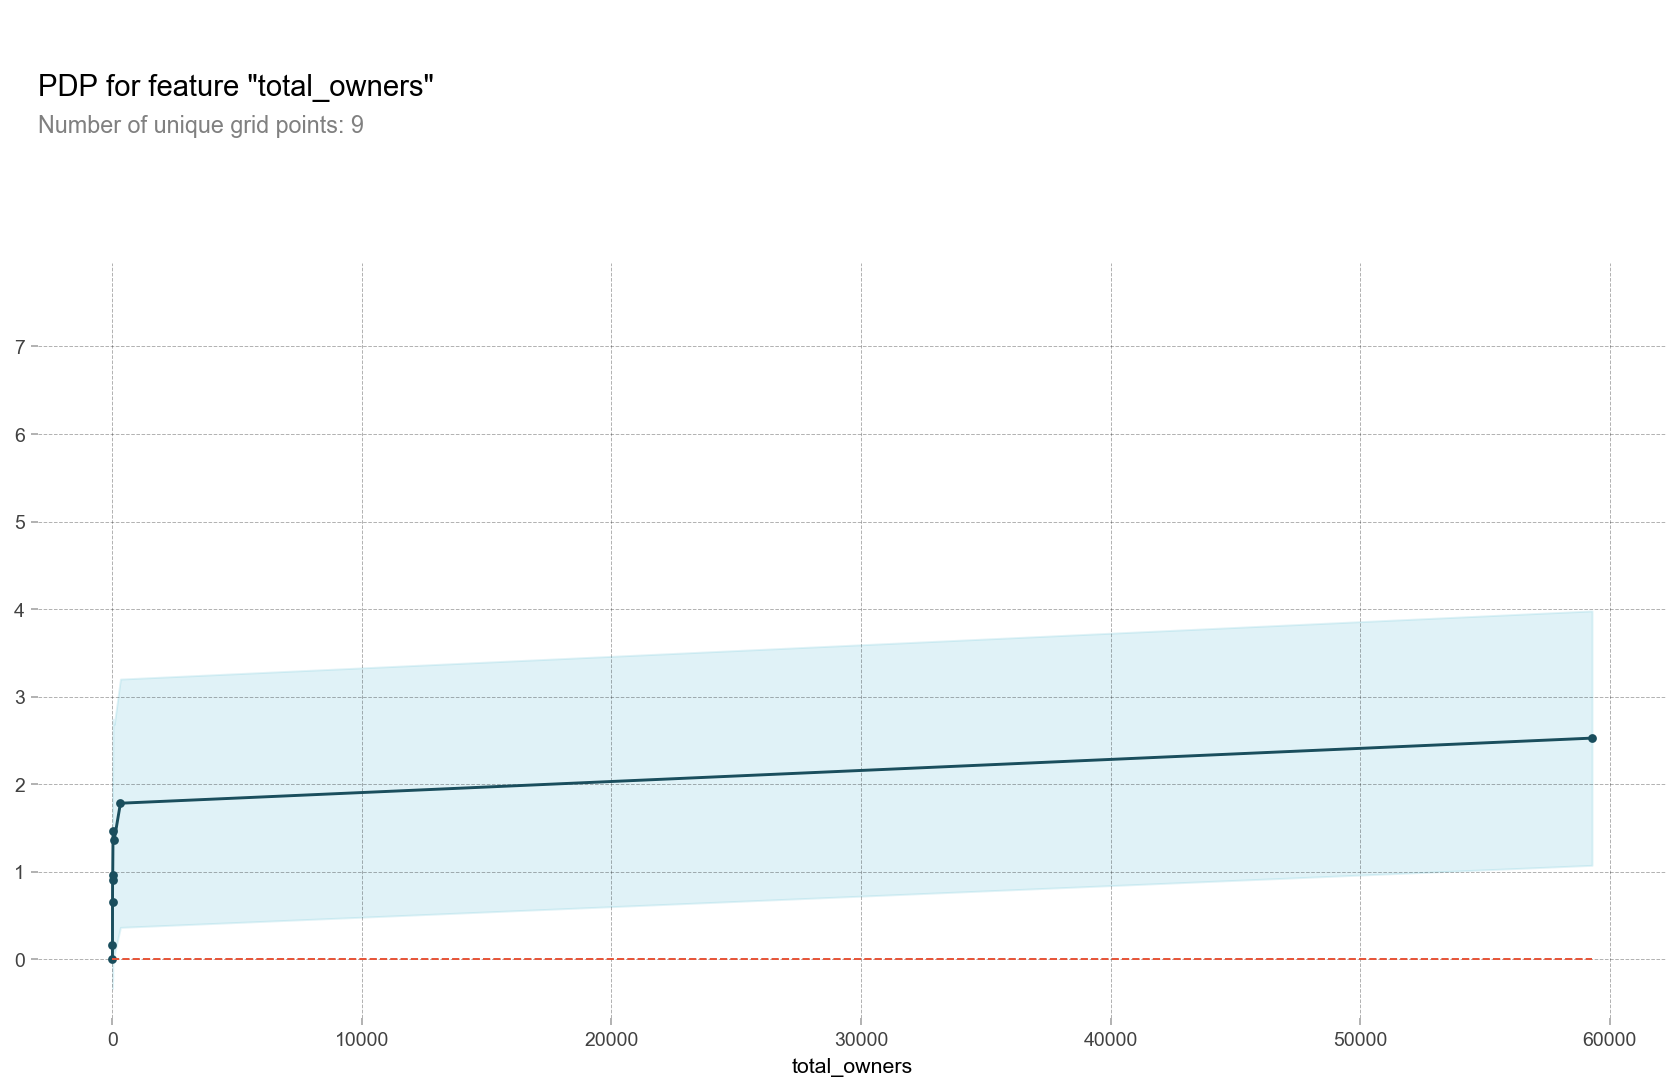

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'total_owners'

isolated = pdp_isolate(
    model=pipeline_boost, 
    dataset=X_val_no_na, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

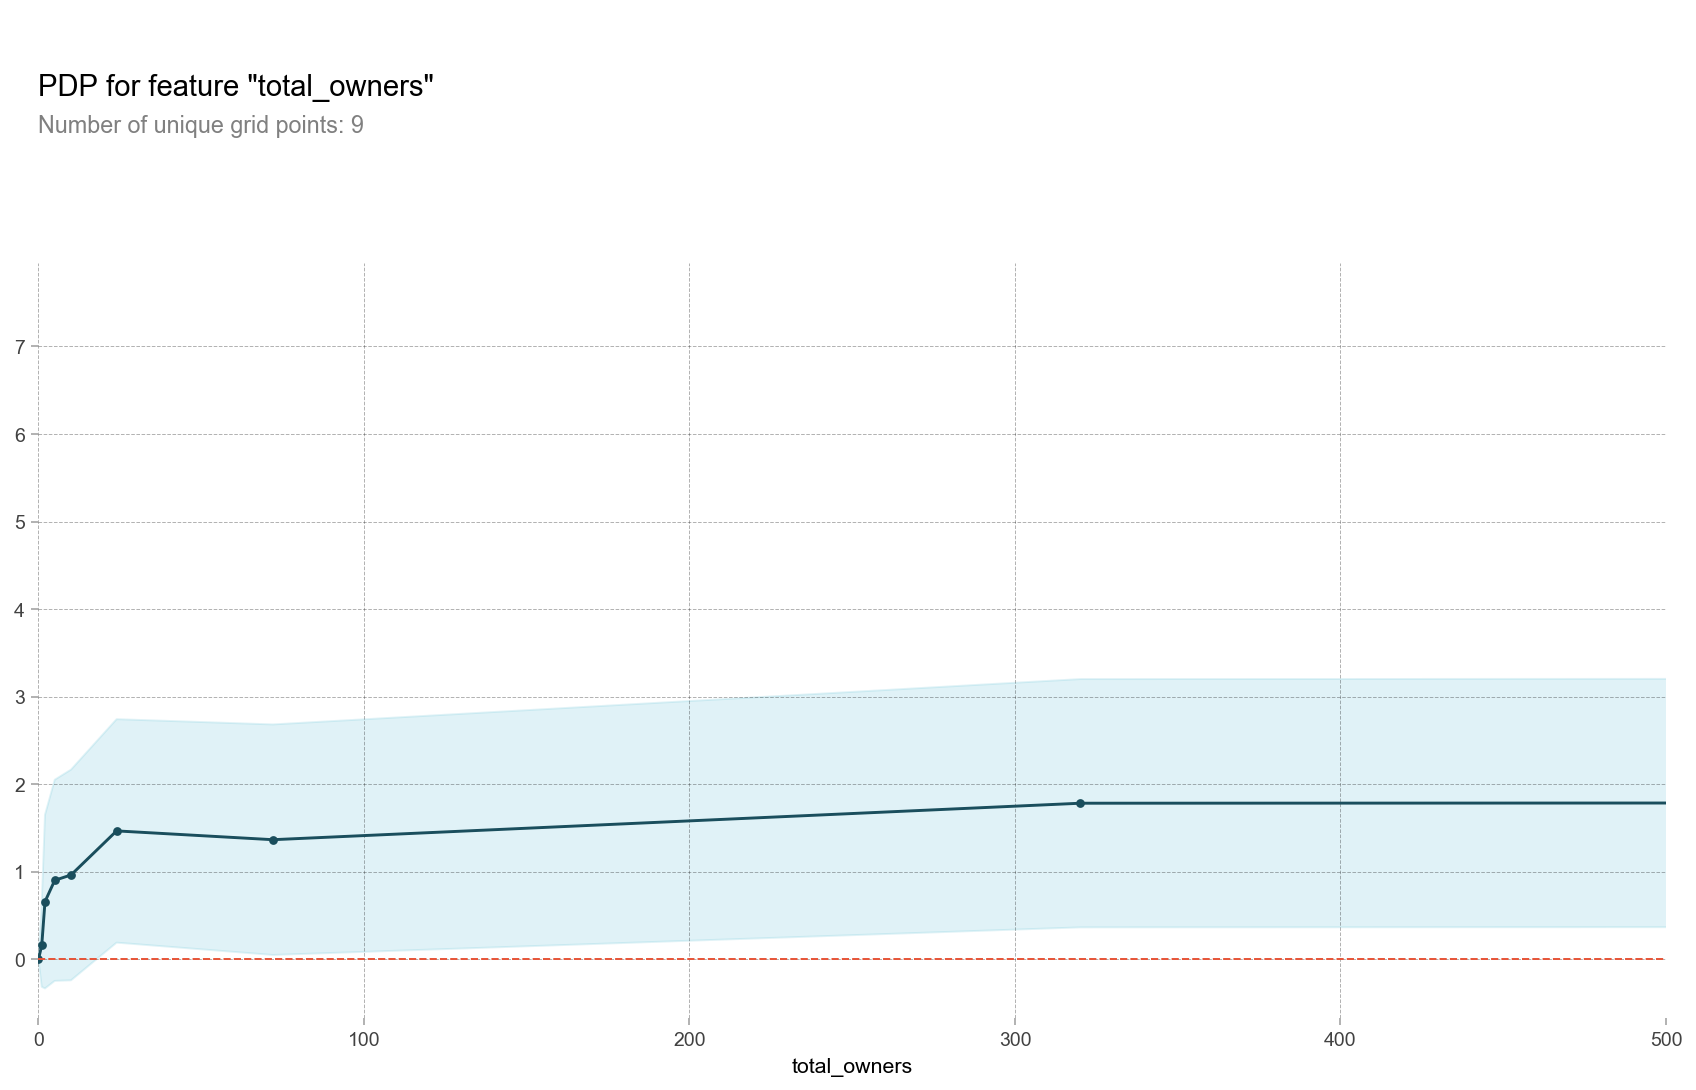

In [0]:
pdp_plot(isolated, feature_name=feature);
plt.xlim(0, 500);

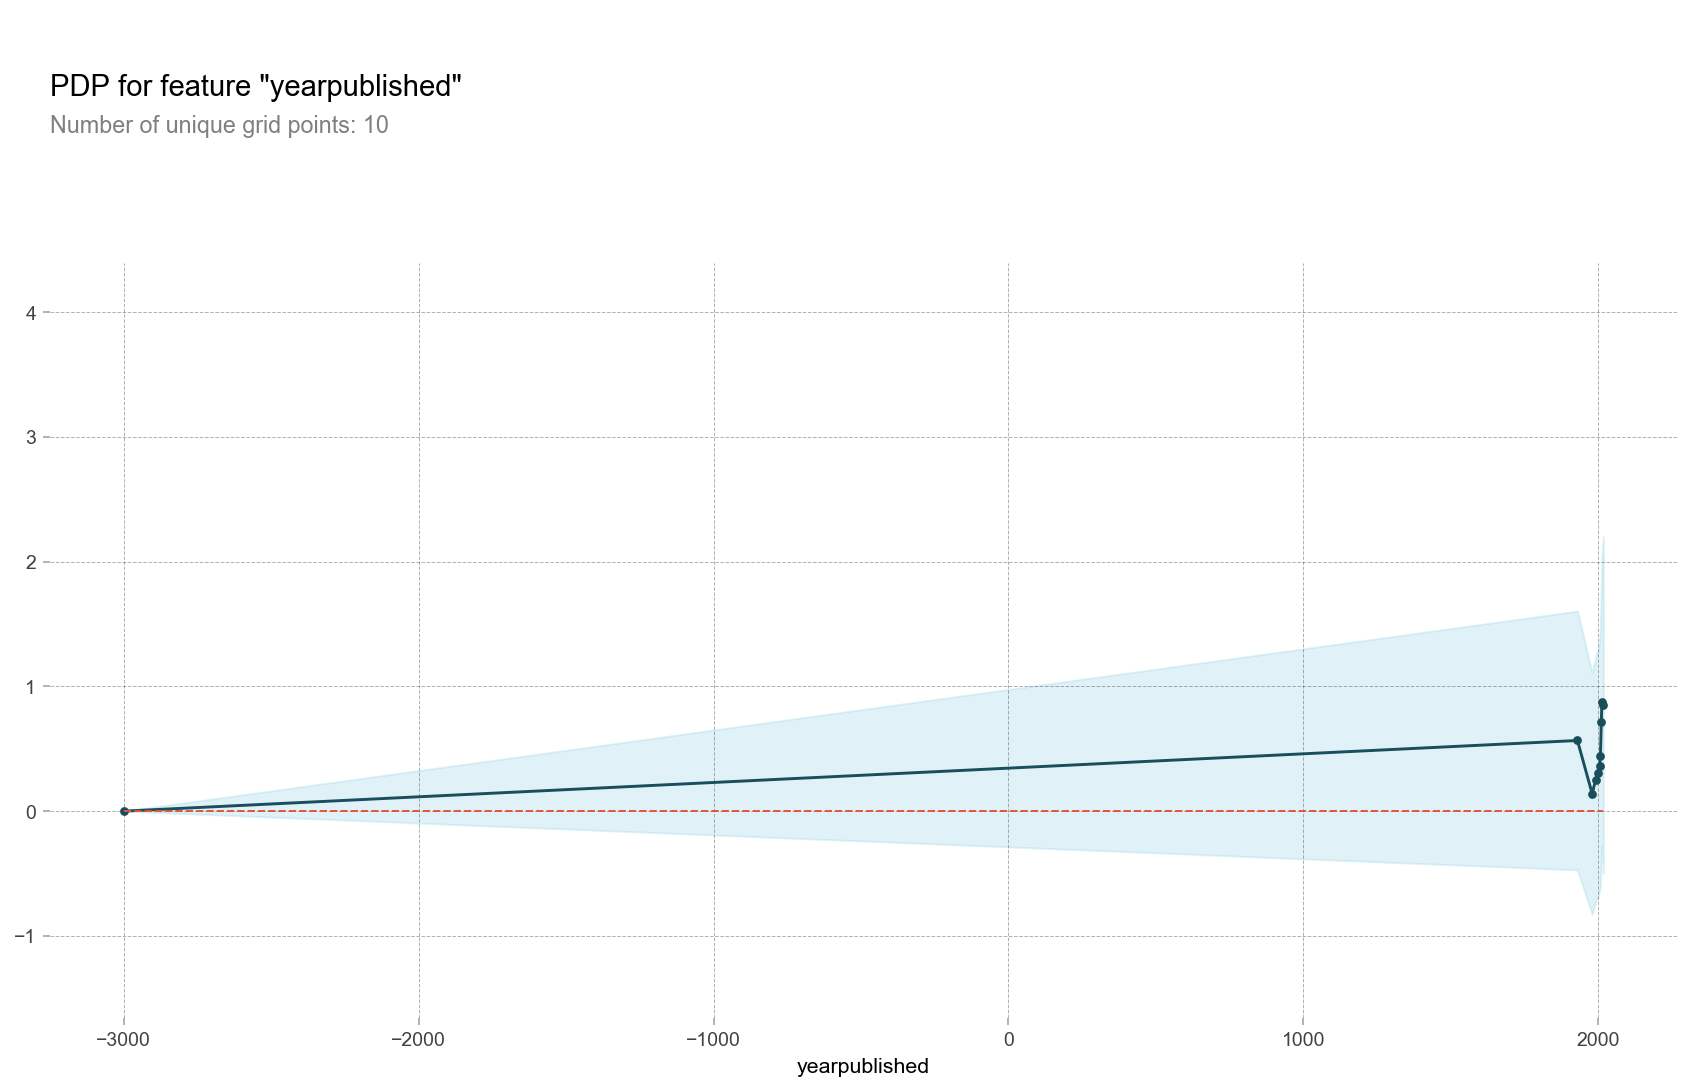

In [0]:
feature = 'yearpublished'

isolated = pdp_isolate(
    model=pipeline_boost, 
    dataset=X_val_no_na, 
    model_features=X_train.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

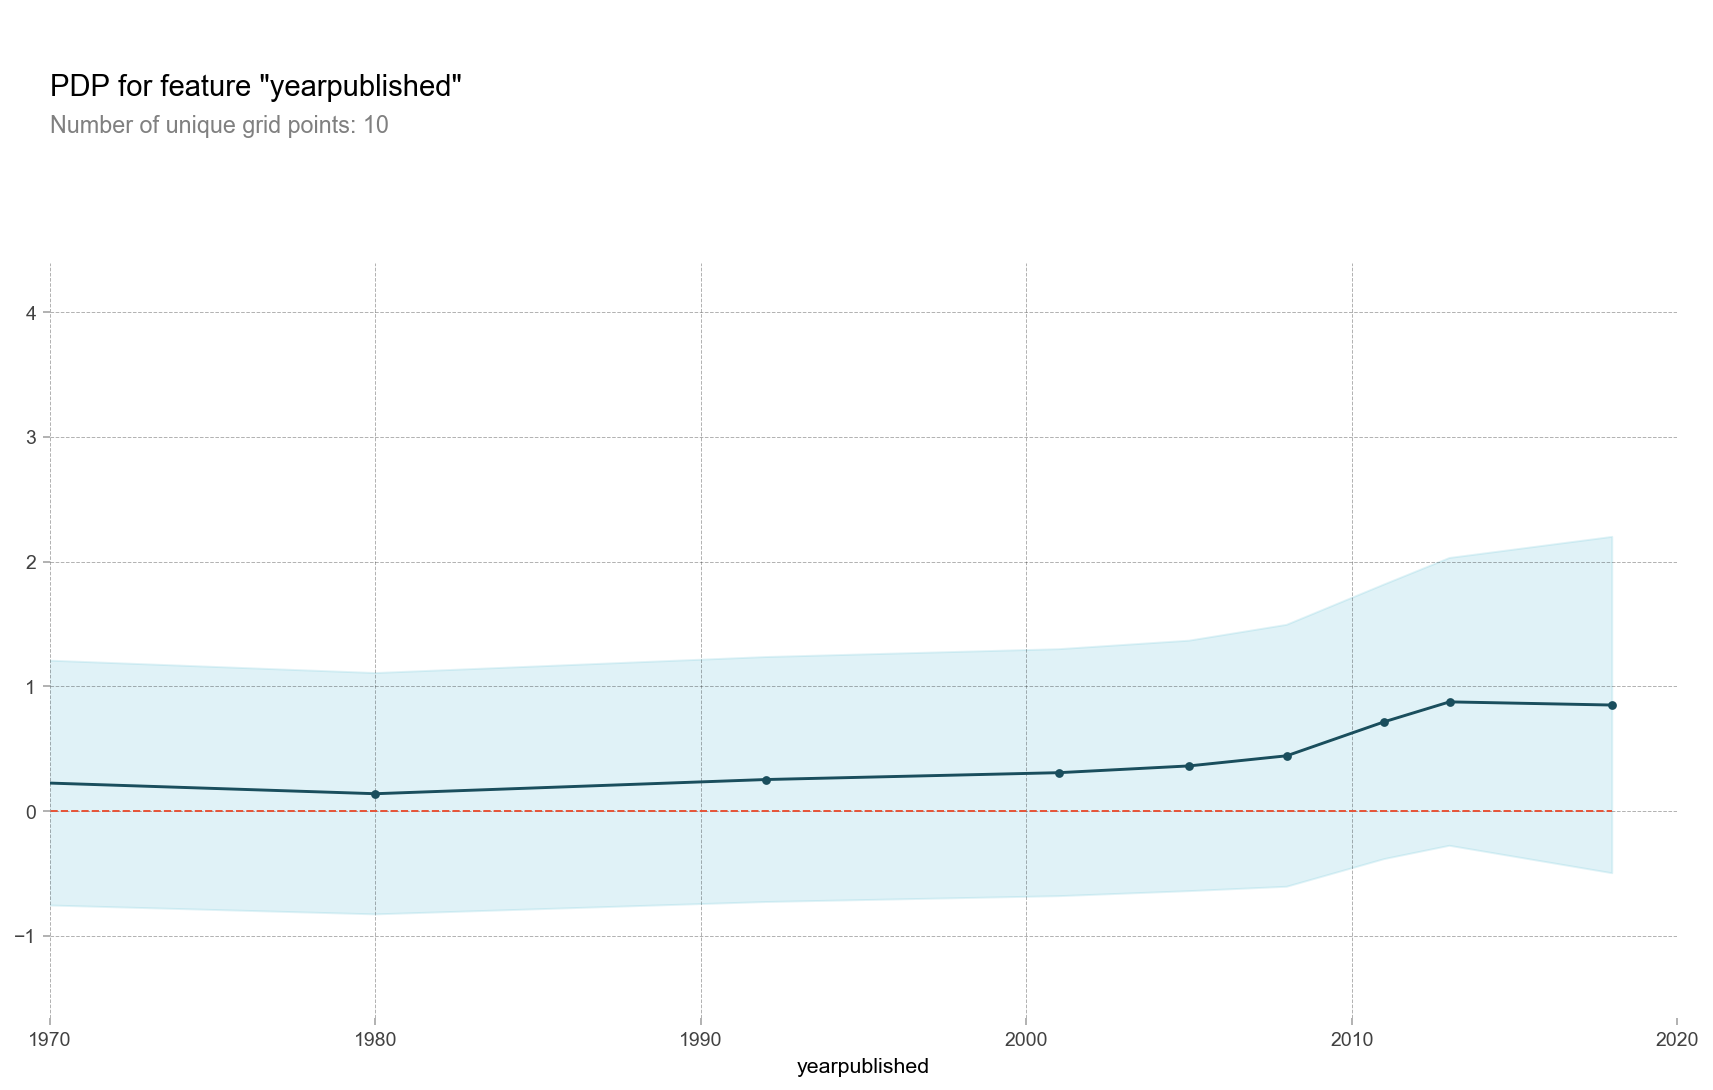

In [0]:
pdp_plot(isolated, feature_name=feature);
plt.xlim(1970, 2020);